## Pràctica 8


In [32]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Math, display
import sympy as sp
from sympy.physics.units.systems import SI
from sympy.physics.units import meter, second, liter, hour, degree, convert_to
from sympy import sin, cos, pi, Abs
import simpy

sp.init_printing()

def show(*args):
    out = ""
    for arg in args:
        if isinstance(arg, (sp.Expr, sp.Eq)):
            arg = sp.latex(arg)
        else:
            arg = str(arg)
        out += arg
    display(Math(out))

qq = "\quad "

<>:25: SyntaxWarning: invalid escape sequence '\q'
<>:25: SyntaxWarning: invalid escape sequence '\q'
C:\Users\samon\AppData\Local\Temp\ipykernel_1360\4176397549.py:25: SyntaxWarning: invalid escape sequence '\q'
  qq = "\quad "


### Exercici 1
- A una cabina experimental es genera ozó, que és un gas tòxic que volem extreure.
- Hem modelitzat l'extracció d'ozó de la següent manera:
$$x'  = -x \cdot Q/V + O \cdot R $$

on $x$ representa la concentració del gas, $Q$ representa el flux d'extracció d'aire, $V$ és el volum de l'habitació, $O$ és la concentració d'oxigen a l'aire i $R$ és el ritme de generació d'ozó.

Els valors mesurats dels paràmetres són els següents:
- La generació d'ozó es produeix a un ritme d'una molècula d'ozó per cada $(3.7 \pm 0.1) \times 10^9$ molècules d'oxigen per segon.
- La concentració d'oxigen a l'aire és de $20.9476 \pm 0.0005 \%$
- La cabina experimental té un volum de $125.4 \pm 0.8 \, m^3$


#### Dades
- Per validar el model hem fet unes proves irradiant un volum d'aire amb un extractor.
    - Volum d'aire $1.0000 \pm 1\times10^{-4} m^3$
    - Cabal d'aire de l'extractor $1.0 \pm 0.1 \,l/s$
    - La precisió de les mesures de concentració és de $1\times10^{-3}$ ppm

Index(['t (s)', 'Concentració (ppm)'], dtype='object')


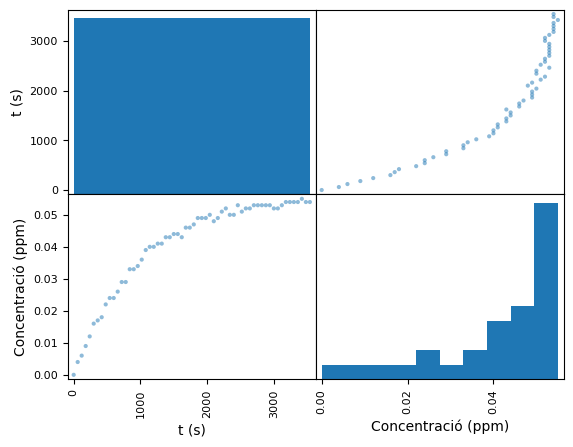

In [33]:
# Dades
data = pd.read_csv("https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/data/ozo.csv")
print(data.columns)
l = pd.plotting.scatter_matrix(data[data.columns])

- Fes la validació del model i una anàlisi crítica considerant que l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm

### Definició dels errors

Per calcular l'error del cas $R$, ja que al model sustituïrem $1/R$:
$$R = \frac{1}{a}$$  $$a = 3.7 \cdot 10^9$$  $$U_a = 0.1\cdot 10^9$$ $$U_R = \left| \frac{dR}{da} \right| \cdot U_a = \frac{1}{a^2}U_a = \frac{0.1 \cdot 10^9}{(3.7 \cdot 10^9)} = 7.304 \cdot 10^{-12} $$

En altre cas, per exemple, $R = a^2$ l'únic que canviaria és la derivada.$$$$

In [34]:
times = data['t (s)'].values

### Pas 1 definim l'equació i la resolevm:

In [35]:
from IPython.display import display, Math
from scipy.integrate import odeint


t, Q, V, O, R = sp.symbols('t Q V O R', real=True, positive=True)
u_q, u_r, u_v, u_o = sp.symbols('u_q u_r u_v u_o', positive=True)


x = sp.Function('x')(t)
xp = sp.diff(x, t)

fx = -x*Q/V + O*R

eq = sp.Eq(xp, fx)
ics = {x.subs(t,0): 0}

In [36]:
valors_validacio = {
    Q : 1e-3,
    V : 1,
    O : 20.9476/100,
    R : 1/(3.7*1e9),
}

a) Amb la funció sp.dsvole (solució anàlita)

In [37]:
sol = sp.dsolve(eq, x, ics=ics) 
xt = sol.rhs * 1e6

display(Math(f"x(t) = {sp.latex(xt)}"))

<IPython.core.display.Math object>

In [38]:
U_x = sp.Function('U_x')(Q, R, V, O, t)

U_x = ((sp.diff(xt, Q)*u_q)**2 + (sp.diff(xt, R)*u_r)**2 + (sp.diff(xt, V)*u_v)**2 + (sp.diff(xt, O)*u_o)**2)**0.5

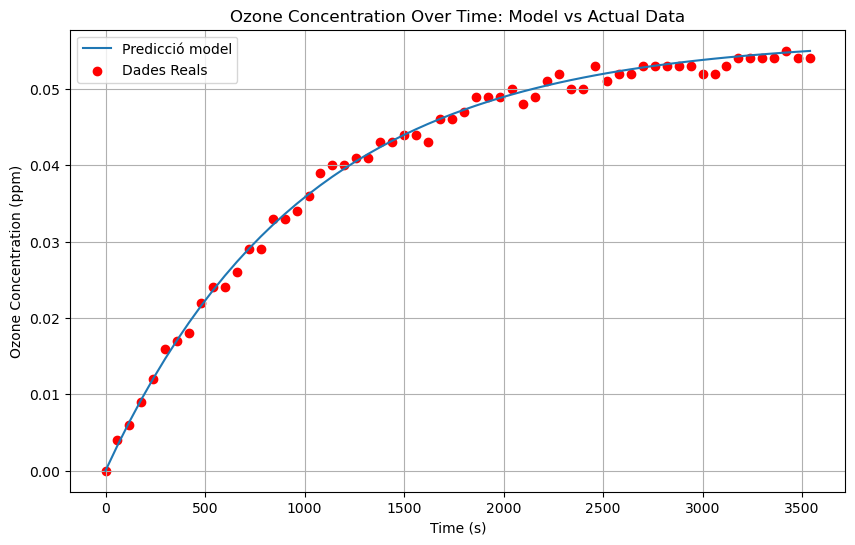

In [39]:
xt.subs(valors_validacio)
fxt = sp.lambdify(t, xt.subs(valors_validacio))

prediccions = fxt(times)

# Definim figura
plt.figure(figsize=(10, 6))
# Fem plot lineal de la predicció del model
plt.plot(times, prediccions, label='Predicció model')

# Plot dels data points de les dades reals
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Ozone Concentration (ppm)')
plt.title('Ozone Concentration Over Time: Model vs Actual Data')
plt.legend()
plt.grid(True)

b) Amb la funció odeint (solució numèrica)

In [40]:
# Definm els valors
"""
Q = 1.0e-3
V = 1.0
O = 20.9476 / 100
R = 1.0 / (3.7e9)

# Definim la función derivada
def model(x, t):
    return -x * Q / V + O * R

# Condición inicial
x0 = 0

# Resolvem la edo
x_solution = odeint(model, x0, times)

# Convertir a ppm
x_ppm = x_solution.flatten() * 1e6
x_ppm
"""

'\nQ = 1.0e-3\nV = 1.0\nO = 20.9476 / 100\nR = 1.0 / (3.7e9)\n\n# Definim la función derivada\ndef model(x, t):\n    return -x * Q / V + O * R\n\n# Condición inicial\nx0 = 0\n\n# Resolvem la edo\nx_solution = odeint(model, x0, times)\n\n# Convertir a ppm\nx_ppm = x_solution.flatten() * 1e6\nx_ppm\n'

In [41]:
"""
# Definim figura
plt.figure(figsize=(10, 6))
# Fem plot lineal de la predicció del model
plt.plot(times, x_ppm, label='Predicció model')

# Plot dels data points de les dades reals
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Ozone Concentration (ppm)')
plt.title('Ozone Concentration Over Time: Model vs Actual Data')
plt.legend()
plt.grid(True)
"""

"\n# Definim figura\nplt.figure(figsize=(10, 6))\n# Fem plot lineal de la predicció del model\nplt.plot(times, x_ppm, label='Predicció model')\n\n# Plot dels data points de les dades reals\nplt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')\n\n# Add labels and legend\nplt.xlabel('Time (s)')\nplt.ylabel('Ozone Concentration (ppm)')\nplt.title('Ozone Concentration Over Time: Model vs Actual Data')\nplt.legend()\nplt.grid(True)\n"

### Pas 2 calculem la discrèpancia del model

$D = S - P$

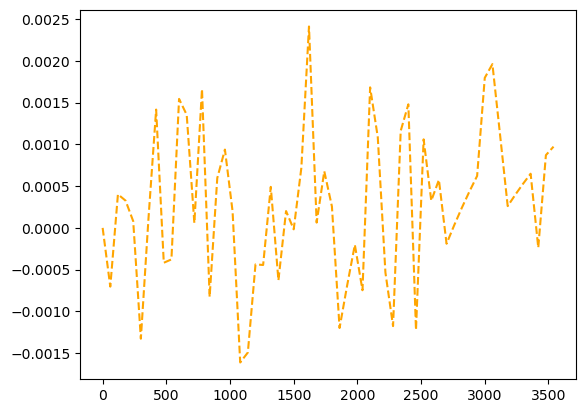

In [42]:
E_p = prediccions - data['Concentració (ppm)']
plt.plot(times, E_p, label='Discrepancies', color='orange', linestyle='--')

Mean discrepancy: 0.00027158948741160216


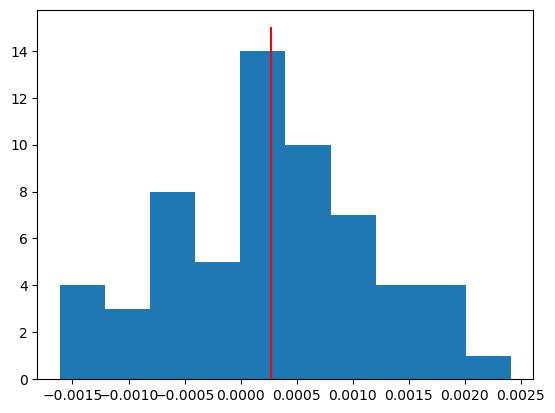

In [43]:
mean_discrepancy = np.mean(E_p)
plt.hist(E_p)
plt.vlines(mean_discrepancy, color='red', label='Mean Discrepancy', ymin=0, ymax=15)
print("Mean discrepancy:", mean_discrepancy)

### Pas 3 definim els errors i calculem la incertesa

Sabem que la incertesa es calcula amb la següent expressió, la propagació d'errors:
$$U_x = \sqrt{\sum_{i} (\frac{\partial x}{\partial i} U_i)^{2}}$$ On $i$ són les variables i $U_i$ els errors d'aquestes.

In [44]:
valors_u = {
    u_q : 0.1*1e-3,
    u_r : 7.304*1e-12,
    u_v : 1e-4,
    u_o : 0.0005/100
}

In [45]:
display(Math(f"U_x(Q, R, V, O, t) = {sp.latex(U_x)}"))

<IPython.core.display.Math object>

In [46]:
# Substituïm els valors
U_x_t = U_x.subs(valors_validacio).subs(valors_u)
display(Math(f"U_x(t) = {sp.latex(U_x_t)}"))

<IPython.core.display.Math object>

In [47]:
fUx = sp.lambdify(t, U_x_t)
uncertainty_values = fUx(times) 

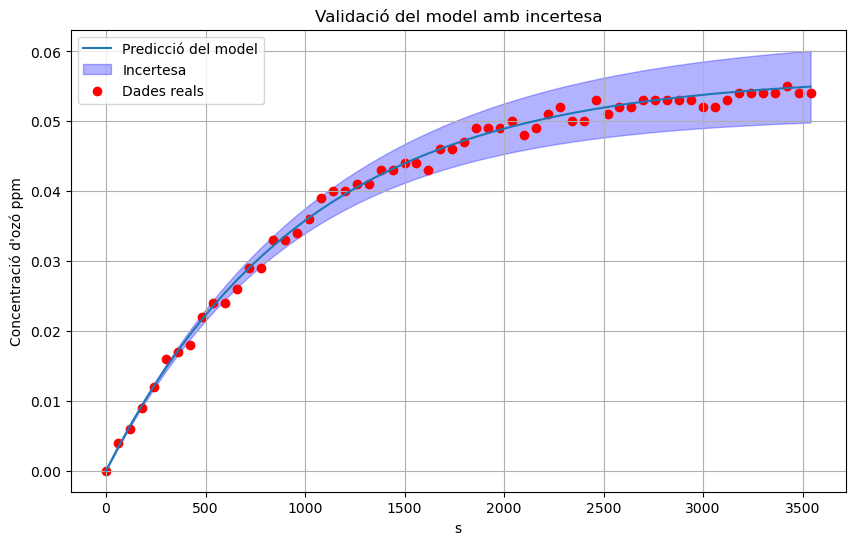

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(times, prediccions, label='Predicció del model')
plt.fill_between(times, prediccions - uncertainty_values, prediccions + uncertainty_values, color='blue', alpha=0.3, label='Incertesa')
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades reals')
plt.xlabel('s')
plt.ylabel('Concentració d\'ozó ppm')
plt.title('Validació del model amb incertesa')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Limits inferiors i superiors
lower_bound = prediccions - uncertainty_values
upper_bound = prediccions + uncertainty_values

within_interval = (data['Concentració (ppm)'] >= lower_bound) & (data['Concentració (ppm)'] <= upper_bound)

percent_within_interval = within_interval.sum() / len(E_p) * 100
print(f"{percent_within_interval:.2f}% de les dades estan dins la franja d'incertesa del model")

86.67% de les dades estan dins la franja d'incertesa del model


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['t (s)'],uncertainty_values)
plt.title('Incertesa absoluta')
plt.xlabel('Temps')
plt.ylabel('Incertesa')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#incertesa relativa
#plt.plot(times, uncertainty_values/prediccions)
#plt.show()

In [ ]:
#Error del model 
plt.figure(figsize=(10, 6))
plt.plot(data['t (s)'],E_p+uncertainty_values,color='blue',alpha=0.3)
plt.plot(data['t (s)'],E_p)
plt.plot(data['t (s)'],E_p-uncertainty_values,color='blue',alpha=0.3)
plt.fill_between(data['t (s)'],
                 E_p - uncertainty_values,
                 E_p + uncertainty_values,
                 color='gray', alpha=0.3, label='Incertesa')
plt.title('Error del model')
plt.xlabel('Temps')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

Aleshores, podem considerar que el model queda validat, ja que, tal com es mostra a la gràfica "Validació del model amb incertesa", tots els valors reals es troben dins de l’interval d’incertesa associat a la predicció del model.

Això implica que el model no només descriu adequadament el comportament observat, sinó que també inclou la incertesa de manera realista, assegurant que el valor real de la concentració d’ozó per a cada instant de temps es troba dins de la banda d’incertesa mostrada.

A més, a la gràfica "Incertesa total de les prediccions", s’observa clarament com la incertesa augmenta amb el temps. Aquest fet és conseqüència de la propagació dels errors dels paràmetres del model i de la incertesa de mesura (
±
0.001
 
ppm
±0.001ppm). Inicialment, la incertesa és de 0.001, però al final del procés és unes 5 vegades més gran, fet que evidencia com la precisió disminueix amb el temps.

Per tant, es conclou que el model és coherent amb les dades experimentals i les seves incerteses, i per tant queda validat. A continuació, es realitzarà una anàlisi crítica sobre l’evolució de l’ozó a l’interior de l’habitació.

### Cas de l'habitació

In [ ]:
valors = {
    Q : 1e-3,
    V : 125.4,
    O : 20.9476/100,
    R : 1/(3.7*1e9),
}
temps = np.linspace(0, 1000000, 60)

In [ ]:
xt_h = xt.subs(valors)
fxth = sp.lambdify(t, xt_h.subs(valors))
xt_h

In [ ]:
dph = fxth(temps)

plt.plot(temps, dph, label='Predicció del model')  # Dibuixa la predicció
plt.axhline(y=0.1, color='green', linestyle='--', label='Nivell de seguretat')  # Línia horitzontal
plt.axhline(y=5, color='red', linestyle='--', label='Tòxic')  # Línia horitzontal


plt.xlabel('Temps (s)')
plt.ylabel('Concentració (ppm)')
plt.legend()
plt.grid(True)
plt.show()

### Exercici 2

Tenim un taller en el qual hi ha 5 màquines idèntiques que processen tasques que arriben de forma aleatòria cada 12 minuts de mitjana.
Les tasques s’assignen a qualsevol màquina que estigui lliure, o fan cua esperant que hi hagi alguna màquina lliure.
El temps necessari per completar una tasca també és aleatori, però de mitjana es triga una hora per a totes les tasques i màquines.

Al taller hi treballen 3 operaris, que tenen dues feines principals:

- Preparar les màquines perquè inicien la tasca que ha arribat.

- Reparar una màquina que ha fallat.

La preparació de la tasca necessita un temps aleatori, però que de mitjana és de 20 minuts.
La reparació necessita dos operaris i un temps aleatori, que de mitjana és de mitja hora.
Quan ha finalitzat una tasca, el 20% dels cops cal reparar la màquina.

- Fes 10 simulacions d'una setmana i calcula la llargària mitjana de la cua de tasques.

- Què faries per reduir la cua de tasques i per què?


### Resum

Recursos:
- Màquines x5
- Tècnics x3

Processos:
- Processar tasca
    - sí trencat
    - no trencat
- Arribada
- Reparació
- Carregar

Relacions:
- Arr -> Carr -> Process
    - Process -> Carr
    - Process -> Reparar -> Carr
    
Demanen: Llarg Cua
Tenim Log (pd) on anem guardant la llargària de la cua

In [ ]:
def processar(enviroment,log,maquines,treballadors):
    with maquines.request() as maq:
        log.append({
            "temps": enviroment.now,
            "cua_maquines": len(maquines.queue)
        })

        yield maq
        #preparació
        with treballadors.request() as tr:
            yield tr
            temps = np.random.exponential(scale=20)
            yield enviroment.timeout(temps)
        
        #completació
        temps = np.random.exponential(scale=60)
        yield enviroment.timeout(temps)

        #reparació
        if np.random.rand() < 0.2: 
            with treballadors.request() as tr1, treballadors.request() as tr2:
                yield tr1 & tr2
                temps = np.random.exponential(scale=30)
                yield enviroment.timeout(temps)


In [ ]:
def arribades(env, logs,maquines,treballadors):
    while True:
        temps = np.random.exponential(12)
        yield env.timeout(temps)
        env.process(processar(env, logs, maquines, treballadors))

In [ ]:
def simulacio():
    env = simpy.Environment()
    logs = []
    maquines = simpy.Resource(env, capacity=5)
    treballadors = simpy.Resource(env, capacity=3)
    env.process(arribades(env, logs, maquines, treballadors))
    env.run(until=7 * 24 * 60)  # Simulació durant una setmana en minuts
    return logs

In [ ]:
res = [simulacio() for _ in range(10)]

for i, r in enumerate(res):
    df = pd.DataFrame(r)  # convertir la llista de dicts en DataFrame
    plt.plot(df["temps"], df["cua_maquines"], label=f"Simulació {i+1}")

    # Calcular pesos com la diferència entre temps consecutius
    df["delta_temps"] = df["temps"].diff().shift(-1)  # el temps que dura cada observació
    df = df[:-1]  # eliminar l'última fila que té NaN a delta_temps

    # Mitjana ponderada: sum(cua * delta_t) / sum(delta_t)
    mitjana_ponderada = (df["cua_maquines"] * df["delta_temps"]).sum() / df["delta_temps"].sum()
    
    print(f"Simulació {i+1}: Llargària mitjana ponderada de la cua de tasques: {mitjana_ponderada:.2f}")


plt.xlabel("Temps (minuts)")
plt.ylabel("Mida de la cua de màquines")
plt.title("Evolució de la cua de màquines en diferents simulacions")
plt.legend()
plt.grid(True)
plt.show()


### Exercici 3

Analitza la següent cadena de Markov:
[<center><img src=https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/notebooks/static/markov.png width=25%></center>](#bib_Konstantopoulos)

- Escriu la matriu de transició
- És irreductible?
- És aperiòdica?
- Si comencem a l'estat 1, quina probabilitat n'hi ha que ens trobem a cada un dels estats deprés de 3 passes?
- Troba la distribució d'estats estable si existeix.

In [ ]:
# Matriu de transició
P = np.array([
    [1/2, 1/3, 1/6],
    [3/4, 0, 1/4],
    [0, 1, 0]
])

Irreductible: És irreductible si desde qualsevol estat es pot anar a qualsevol estat.

In [ ]:
import networkx as nx

def is_irreducible(P):
    n = P.shape[0]
    G = nx.DiGraph()
    
    for i in range(n):
        for j in range(n):
            if P[i, j] > 0:
                G.add_edge(i, j)

    return nx.is_strongly_connected(G)

In [ ]:
if is_irreducible(P):
    print("The Markov chain is irreducible.")
else:
    print("The Markov chain is not irreducible.")

Aperiòdica: Una matriz de transición (en cadenas de Markov) es aperiódica si, para cada estado, el sistema puede volver a ese estado en distintos múltiplos de pasos sin seguir un ciclo fijo.
Formalmente, un estado 𝑖 tiene período 𝑑 si 𝑑 es el máximo común divisor (MCD) de todos los números 𝑛 tales que 𝑃𝑛(𝑖,𝑖)>0. Una cadena de Markov es aperiódica si todos los estados tienen período 1.

In [ ]:
from math import gcd
from functools import reduce

def get_period(P, state):
    #Aquesta funcio en principi funciona pero es una mica marronera
    #Jo ho faria a ma i utilitzaria aquesta per tenir una segona
    #comprobació
    n = P.shape[0]
    max_power = 100  
    periods = []

    reachable_times = []
    P_power = np.eye(n)
    
    for k in range(1, max_power+1):
        P_power = np.matmul(P_power, P)
        if P_power[state, state] > 1e-12:  
            reachable_times.append(k)
    
    if not reachable_times:
        return None 

    period = reduce(gcd, reachable_times)
    return period


In [ ]:
d = {0: -5, 1: -5, 2: -5}
for i in d.keys():
    d[i] = get_period(P, i)
for i in d.keys():
    print(f"d_{i} = {d[i]}")

És aperiòdica

Probabilitat després de 3 passes

In [ ]:
# Comencem a l'estat 1:
p0 = np.array([1,0,0])
# P3 = np.linalg.matrix_power(P, 3)
P3 = P @ P @ P

# Per saber les probabilitats després de n passos començant a l'estat 1 cal calcular: p0 * P^n
probabilitats = p0 @ P3
probabilitats

Troba la distribució d'estats estable si existeix.

In [ ]:
# Creem el sistema (P^T - I)*π^T = 0
# El nostre sistema a resoldre serà Ax = b
I = np.eye(3)
A = P.T - I
b = np.zeros(3)

# Modifiquem el sistema per afegir la condició de la suma 
# Substituïm la darrera equació π_1 + π_2 + π_3 = 1
A[-1] = np.ones(3)
b[-1] = 1

# Resolem el sistema d'equacions lineals
pi = np.linalg.solve(A, b)

# Resultats
print(f"La distribució estacionaria és: {pi}")